# Model Selection

In [8]:
import pandas as pd
import numpy as np
import glob, sys, os
sys.path.append('..')

In [9]:
from modules.plotting_metrics import PlotMetric
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk', font_scale=0.8)

In [10]:
## Run the helper fucntions form the local CDK2 directory
%run ./helper_1_load_data.ipynb

In [11]:
# Helper fucntion to train and test
%run ./helper_functions_S6.ipynb

In [117]:
file_name = './df_DkSc_results_COCRYS_DEKOIS_DUD.pkl'
X_merged_dksc = pd.read_pickle(file_name)
# Extract activity column
y_true_merged = X_merged_dksc['activity']
# Drop column from merged_dkksc
X_merged_dksc = X_merged_dksc.drop('activity', axis=1)
X_merged_dksc.shape

(5839, 136)

## Scaffold Splitting

In [157]:
from rdkit.Chem.Scaffolds import MurckoScaffold 
from rdkit.Chem import MolToSmiles
from rdkit.Chem import rdDepictor

to2d = Chem.rdDepictor.Compute2DCoords

# Define a lambda function to compute Murcko scaffolds
def scaffold2smiles(mol, generic=True, return_smiles = True):
    ''' Returns a SMILES string representing the Murcko Scaffold of a given molecule'''
    if generic:
        # Makes a Murcko scaffold generic (all atoms -> carbon and all bonds -> single)
        scff = MurckoScaffold.MakeScaffoldGeneric(mol)
        scff = MurckoScaffold.GetScaffoldForMol(scff)
        scff_smiles = MolToSmiles(scff)
    else:
        # Return a smiles scaffold 
        try:
            scff = MurckoScaffold.GetScaffoldForMol(mol)
            scff_smiles =  MolToSmiles(scff)
        except:
            scff_smiles = '' 
            scff = np.nan
    if return_smiles:
        return scff_smiles
    else:
        return scff

In [186]:
from rdkit import Chem

def scaffold_splitter(scaffold_series, train_size=0.8, valid_size=0, test_size=0.2):
    '''
    Performs a Train Test splitting using Murcko Scaffolds.
    
    Parameters:
    -----------
        scaffold_series: pandas Series.
            Series object with precomputed Murcko Scaffolds (SMILES format).
        train_size, test_size, valid_size: float.
            Train, Validation and Test fraction size for each subset.
    Retunrs:
    --------
        train_inds, valid_inds, test_inds: array-like.
            Arrays containing the molecule indices of the corresponding train, test subset.
    '''
    
    np.testing.assert_almost_equal(train_size + test_size + valid_size, 1.0)
    
    scaffolds = {}
    data_len = scaffold_series.shape[0]
    
    for ind, scff in enumerate(scaffold_series):
        if scff not in scaffolds:
                scaffolds[scff] = [ind]
        else:
            scaffolds[scff].append(ind)
    # Sort from largest t smallest scaffold sets
    scaffolds = {key: sorted(value) for key, value in scaffolds.items()}
    # Scaffold sets
    scaffold_sets = [
        scff_set
        for (scff, scff_set) in sorted(
            scaffolds.items(), key=lambda x: (len(x[1]), x[1][0]), reverse=True)
    ]
    
    # create Train and Test sets
    train_cutoff = train_size * data_len
    valid_cutoff = (train_size + valid_size) * data_len
    
    train_inds, valid_inds, test_inds = [], [], []
    # Full Train-Test sets
    for scff_set in scaffold_sets:
        if len(train_inds) + len(scff_set) > train_cutoff:
            if len(train_inds) + len(valid_inds) + len(scff_set) > valid_cutoff:
                test_inds += scff_set
            else:
                valid_inds += scff_set
        else:
            train_inds += scff_set
    return train_inds, valid_inds, test_inds
    
    
def train_test_scaffold_split(X, y, scaffold_series, train_size=0.8, valid_size=0, test_size=0.2):
    '''
    Performs a Train Test splitting using Murcko Scaffolds.
    
    Parameters:
    -----------
        X: pandas DataFrame.
            Dataframe with m rows and n columns.
        y: pandas Series.
            Series object with m target values. Index values should match those in X.
        scaffold_series: pandas Series.
            Series object with precomputed Murcko Scaffolds (SMILES format).
        train_size, test_size, valid_size: float.
            Train, Validation and Test fraction size for each subset.
    Retunrs:
    --------
        X_train, X_test: pandas DataFrame.
            Train and Test X subset accordingly to the Scaffold Splitting.
        y_train, y_test: pandas Series.
            Train and Test target values.
    '''

    assert (X.index == scaffold_series.index).all(), 'Index should be the same between X and rdk_mols_series'
    assert len(X) == len(y), 'Numer of observations in X and y is not the same.'
    
    train_inds, _, test_inds = scaffold_splitter(scaffold_series,
                                    frac_train=frac_train, frac_valid=frac_valid, frac_test=frac_test)
    # Subset X and y
    X_train = X.iloc[train_inds]
    y_train = y.iloc[train_inds]
    X_test = X.iloc[test_inds]
    y_test = y.iloc[test_inds]
    
    return X_train, y_train, X_test, y_test 

In [161]:
%%time
# Compute or load the dataframe containing the Generic Murcko Scaffolds
file = './df_COCRYS_DUD_DEKOIS_Murcko_Scaffolds_SMILES.pkl'

if os.path.isfile(file):
    df_scff_murcko = pd.read_pickle(file)
else:
    # Load the dataframe where repeated molecules have already been dropped 
    pkl_file = './df_COCRYS_DUD_DEKOIS_with_Fingerprints_2.pkl'
    df_dim_mds = pd.read_pickle(pkl_file)[['library', 'name', 'mol_rdk']] # Only keep useful columns
    # Set index
    df_scff_murcko = df_dim_mds.set_index(['library', 'name'])
    # Compute Generic Murko Scaffolds
    df_scff_murcko['murcko_scff_gen'] = df_dim_mds.mol_rdk.apply(scaffold2smiles).values
    # Compute Murko Scaffolds
    df_scff_murcko['murcko_scff'] = df_dim_mds.mol_rdk.apply(scaffold2smiles, generic=False).values
    # Save the file
    df_scff_murcko.to_pickle(file)

CPU times: user 390 ms, sys: 306 ms, total: 696 ms
Wall time: 692 ms


## Train/test on the same dataset 

### Learning Curves

In [13]:
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import learning_curve

In [14]:
def plot_learning_curves(estimator, X, y, title, ylim=[0.5,1], axes=None,
                         cv=3, train_sizes=np.linspace(0.1, 1.0, 10), 
                         scoring='roc_auc', n_jobs=4):
    '''
    Plot estimator performance on the training and validation
    sets as a function of the training set size.

    Parameters
    ----------
    estimator: sklearn estimator object type
       Object type that implements the "fit" and "predict method"

    X: array-like, shape (m_samples, n_features)
        Training array with m_samples and n_features.
    y: array-like, shape (m_samples)
        Target array relative to X with m labels.
    axes: array of 3 axes
        matplotlib axes array to append the generated plot
    ylim: array
       
    '''
    if axes == None:
        _, axes = plt.subplots(1, 1, figsize=(5, 5))
        
    axes.set(title=title, ylim=ylim, xlabel='Training examples', ylabel=f'Metric: {scoring}')
    # Use learning_curve function from sklearn
    train_sizes, train_scores, test_scores, fit_times, _ = \
       learning_curve(estimator, X, y, scoring=scoring, return_times = True,
                      cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    # Compute useful metrics
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)
    # Plot the learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                        train_scores_mean + train_scores_std, alpha=0.1, color='r')
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                        test_scores_mean + test_scores_std, alpha=0.1, color='g')
    axes.plot(train_sizes, train_scores_mean, 'o-', color='r',
                label='Train score')
    axes.plot(train_sizes, test_scores_mean, 'o-', color='g',
                label='Cross-validation score')
    axes.legend(loc='lower right')
    

### Hyperparameters tunning: Grid Search

In [15]:
def run_grid_search(estimator, X, y, hyperparams, test_size=0.3, cv_value=5, 
                    scoring='roc_auc', ):
    # Train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y)

    # Format the hyperparms
    hyperparams_dict = {'estimator__' + key: val for key, val in hyperparams.items()}

    # Create the Pipe
    scaler = StandardScaler()
    pipe = Pipeline([('scaler', scaler),
                     ('estimator', estimator)])

    gs = GridSearchCV(estimator = pipe, param_grid = hyperparams_dict,
                     cv = cv_value, scoring = scoring, n_jobs = 6, refit = True)
                    # refit=True means to train the final model using the whole training set

    # Train the model
    gs.fit(X_train, y_train) 

    # Predictions
    y_train_predict = gs.predict_proba(X_train)
    y_test_predict = gs.predict_proba(X_test)

    # Print some values
    print(f'No. of molecules in train set: {y_train.shape[0]}, with {y_train.sum()} actives.')
    print(f'No. of molecules in test set: {y_test.shape[0]}, with {y_test.sum()} actives.')
    print('')
    print('*'*10, 'GRID SEARCH RESULTS', '*'*10)
    print('- Mean CV ROC-AUC score: {:.3f}'.format(gs.best_score_))
    print('- Train ROC-AUC: {:.3f}'.format(roc_auc_score(y_train, y_train_predict[:, 1])))
    print('- Test ROC-AUC: {:.3f}'.format(roc_auc_score(y_test, y_test_predict[:, 1])))
    print('- Best hyperparameters', gs.best_params_)
    print('**'*21)
    print('')

In [16]:
def run_cross_val_bias_var_tradeoff(estimator, X, y, test_size=0.3, cv_value=5, scoring='roc_auc',
                                   score_type='Dk_sc', pred_prob = True, splitting='random'):
    # Set the train and test sets
    if splitting == 'random':
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y)
    elif splitting == 'scaffold':
        X_train, X_test, y_train, y_test = train_test_scaffold_split(X, y, test_size=test_size, stratify=y)
    
    # Print some values
    print(f'No. of molecules in train set: {y_train.shape[0]}, with {y_train.sum()} actives.')
    print(f'No. of molecules in test set: {y_test.shape[0]}, with {y_test.sum()} actives.')

    # Scaler
    scaler = StandardScaler()

    # Set the pipe
    pipe = Pipeline([('scaler', scaler), ('estimator', estimator)])

    # Set the CV score
    roc_cv = cross_val_score(pipe, X_train, y_train, cv=cv_value, scoring=scoring, n_jobs= -1)

    pipe.fit(X_train, y_train)
    
    if pred_prob:
        # Predict proba
        y_predict_train = pipe.predict_proba(X_train)
        y_predict_test = pipe.predict_proba(X_test)
    else:
        y_predict_train = pipe.predict(X_train)
        y_predict_test = pipe.predict(X_test)

    # CV Mean ROC-AUC
    print('CV={} ROC-AUC: {:.4f}'.format(cv_value, roc_cv.mean()))

    # Training ROC-AUC:
    print('Train ROC-AUC: {:.4f}'.format(roc_auc_score(y_train, y_predict_train[:, 1])))

    # Test ROC-AUC:
    print('Test ROC-AUC: {:.4f}'.format(roc_auc_score(y_test, y_predict_test[:, 1])))

## Hyperparameter search Grid Search

In [26]:
#### library = 'DEKOIS'
library = 'DEKOIS'

# Train and test over DEKOIS
X = X_merged_dksc.loc[library]
y = y_true_merged[library]

#### Linear SVM: Random Spliting

In [27]:
%%time
from sklearn.svm import SVC
estimator = SVC(kernel = 'linear', probability=True)
hyperparams = {'C': np.geomspace(1e-12, 1e-3, 4)}

run_grid_search(estimator, X, y, 
                hyperparams = hyperparams, test_size=0.3)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.888
- Train ROC-AUC: 0.892
- Test ROC-AUC: 0.879
- Best hyperparameters {'estimator__C': 1e-12}
******************************************

CPU times: user 362 ms, sys: 2.41 s, total: 2.77 s
Wall time: 15.3 s


In [27]:
%%time
from sklearn.svm import SVC
estimator = SVC(kernel = 'linear', probability=True)
hyperparams = {'C': np.geomspace(1e-12, 1e-3, 4)}

run_grid_search(estimator, X, y, 
                hyperparams = hyperparams, test_size=0.3)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.888
- Train ROC-AUC: 0.892
- Test ROC-AUC: 0.879
- Best hyperparameters {'estimator__C': 1e-12}
******************************************

CPU times: user 362 ms, sys: 2.41 s, total: 2.77 s
Wall time: 15.3 s


### Radial Basis Function SVM

In [35]:
%%time
estimator = SVC(kernel = 'rbf', probability=True)

hyperparams = {'C': np.geomspace(1e-6, 1e0, 4), 'gamma': np.geomspace(1e-6, 1e0, 4)}

run_grid_search(estimator, X, y, hyperparams = hyperparams, test_size=0.3)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.898
- Train ROC-AUC: 0.894
- Test ROC-AUC: 0.880
- Best hyperparameters {'estimator__C': 1e-06, 'estimator__gamma': 1e-06}
******************************************

CPU times: user 491 ms, sys: 101 ms, total: 592 ms
Wall time: 2.2 s


### Logistic Regression

In [42]:
%%time
from sklearn.linear_model import LogisticRegression
estimator = LogisticRegression()

hyperparams = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1], 
             'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}

run_grid_search(estimator, X, y, hyperparams = hyperparams, test_size=0.3, cv_value=5)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.908
- Train ROC-AUC: 0.927
- Test ROC-AUC: 0.839
- Best hyperparameters {'estimator__C': 0.001, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
******************************************

CPU times: user 457 ms, sys: 166 ms, total: 623 ms
Wall time: 757 ms


### K-Neighbors Classifier

In [43]:
%%time
from sklearn.neighbors import KNeighborsClassifier 
estimator = KNeighborsClassifier()

hyperparams = {'n_neighbors': [25, 55, 75, 125, 225], 
               'p': [1, 2], # Distance criterion 1: manhattan and 2: euclidean
               'weights': ['uniform', 'distance']
             }

run_grid_search(estimator, X, y, hyperparams = hyperparams, test_size=0.3, cv_value=5)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.914
- Train ROC-AUC: 1.000
- Test ROC-AUC: 0.765
- Best hyperparameters {'estimator__n_neighbors': 225, 'estimator__p': 2, 'estimator__weights': 'distance'}
******************************************

CPU times: user 756 ms, sys: 117 ms, total: 873 ms
Wall time: 1.71 s


### Decision Tree Classifier

In [47]:
%%time
from sklearn.tree import DecisionTreeClassifier

estimator = DecisionTreeClassifier(splitter='best')
hyperparams = {'criterion': ['gini', 'entropy'], 
               'max_depth': [2, 3, 5],
               'min_samples_split': [0.2, 0.25, 0.3],
               'max_features': [None, 'sqrt', 'log2']}

run_grid_search(estimator, X, y, hyperparams = hyperparams, test_size=0.3, cv_value=5)

No. of molecules in train set: 853, with 27 actives.
No. of molecules in test set: 366, with 12 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.819
- Train ROC-AUC: 0.860
- Test ROC-AUC: 0.874
- Best hyperparameters {'estimator__criterion': 'entropy', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_split': 0.25}
******************************************

CPU times: user 1.04 s, sys: 300 ms, total: 1.34 s
Wall time: 1.66 s


## Baggin Classification

In [63]:
from sklearn.ensemble import BaggingClassifier

In [65]:
# We'll use a DTree 
dtree = DecisionTreeClassifier(max_depth = 5, splitter='best', criterion='entropy', max_features='log2')

# Train/test split
# X = scores_dic['DEKOIS'][score_type]['X']
# y = scores_dic['DEKOIS'][score_type]['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Instantiate the bagging classifier
bc = BaggingClassifier(base_estimator=dtree, n_estimators=300, n_jobs=6)

run_cross_val_bias_var_tradeoff(bc, X, y)

# Create a pipe to standarize values
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('estimator', bc)])

# Fit
pipe.fit(X_train, y_train)

# Predict
y_pred_train = pipe.predict_proba(X_train)
y_pred_test = pipe.predict_proba(X_test)

# Evaluate
train_roc_auc = roc_auc_score(y_train, y_pred_train[:, 1])
test_roc_auc = roc_auc_score(y_test, y_pred_test[:, 1])

print(train_roc_auc)
print(test_roc_auc)

No. of molecules in train set: 3999, with 122 actives.
No. of molecules in test set: 1715, with 53 actives.
CV=5 ROC-AUC: 0.8360
Train ROC-AUC: 0.9586
Test ROC-AUC: 0.8159
0.9604033032131486
0.8507821901323707


In [317]:
# We'll use a KNN classifier
knn = KNeighborsClassifier(n_neighbors=125, p=2, weights='distance')

# Train/test split
X = scores_dic['DEKOIS'][score_type]['X']
y = scores_dic['DEKOIS'][score_type]['y']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Instantiate the bagging classifier
bc = BaggingClassifier(base_estimator=knn, n_estimators=400, n_jobs=6, oob_score=True)

# run_cross_val_bias_var_tradeoff(bc, X, y)

# Create a pipe to standarize values
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('estimator', bc)])

# Fit
pipe.fit(X_train, y_train)

# Predict
y_pred_train = pipe.predict_proba(X_train)
y_pred_test = pipe.predict_proba(X_test)

# Evaluate
train_roc_auc = roc_auc_score(y_train, y_pred_train[:, 1])
test_roc_auc = roc_auc_score(y_test, y_pred_test[:, 1])

print(train_roc_auc)
print(test_roc_auc)
print(pipe['estimator'].oob_score_)

1.0
0.9296296296296296
0.967741935483871


### Random Forest

In [269]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# tuning hyperparameters of a Random Forest 
# Hyperparameters
# 1) number of estimators
# 2) bootstraps

# Optimize
# n_estimators, max_depth, min_samples_leaf, max_features

params_rf = {'n_estimators': [300, 400, 500],
             'max_depth': [4, 6, 8],
             'min_samples_leaf': [0.1, 0.2],
             'max_features': ['log2', 'sqrt']
            }

In [318]:
# instantiate a random forest classifier
rf = RandomForestClassifier(n_estimators=300,
                            min_samples_leaf=0.12)# Create a pipe to standarize values
                            
scaler = StandardScaler()
pipe = Pipeline([('scaler', scaler), ('estimator', rf)])# Fit
pipe.fit(X_train, y_train)

# Predict
y_pred_train = pipe.predict_proba(X_train)
y_pred_test = pipe.predict_proba(X_test)

# Evaluate
train_roc_auc = roc_auc_score(y_train, y_pred_train[:, 1])
test_roc_auc = roc_auc_score(y_test, y_pred_test[:, 1])

print(train_roc_auc)
print(test_roc_auc)

0.9215348639455783
0.9164351851851852


## Voting Classifier

In [217]:
from sklearn.ensemble import VotingClassifier

# Instantiate the classifiers
svm_lin = SVC(kernel = 'linear', probability=True, C=1e-12)
svm_rbf = SVC(kernel = 'rbf', probability=True, C=1e-3, gamma=1e-3)
logReg = LogisticRegression(C=0.001, penalty='l2', solver='liblinear')
dtree = DecisionTreeClassifier(criterion='entropy', 
                               max_depth = 3, max_features='log2', min_samples_split=0.25)

vc = VotingClassifier(estimators = [('logReg', logReg),
                                    ('svm_lin', svm_lin),
                                    ('svm_rbf', svm_rbf),
                                    ('dtree', dtree)
                                   ], voting='soft' )

for clf in [svm_lin, svm_rbf, logReg, dtree, vc]:
    print('*'*30)
    # Train/test
    run_cross_val_bias_var_tradeoff(clf, X, y)


******************************
No. of molecules in train set: 868, with 28 actives.
No. of molecules in test set: 372, with 12 actives.
CV=5 ROC-AUC: 0.8776
Train ROC-AUC: 0.8878
Test ROC-AUC: 0.9074
******************************
No. of molecules in train set: 868, with 28 actives.
No. of molecules in test set: 372, with 12 actives.
CV=5 ROC-AUC: 0.8848
Train ROC-AUC: 0.8966
Test ROC-AUC: 0.8845
******************************
No. of molecules in train set: 868, with 28 actives.
No. of molecules in test set: 372, with 12 actives.
CV=5 ROC-AUC: 0.8780
Train ROC-AUC: 0.9010
Test ROC-AUC: 0.9368
******************************
No. of molecules in train set: 868, with 28 actives.
No. of molecules in test set: 372, with 12 actives.
CV=5 ROC-AUC: 0.7379
Train ROC-AUC: 0.8727
Test ROC-AUC: 0.8076
******************************
No. of molecules in train set: 868, with 28 actives.
No. of molecules in test set: 372, with 12 actives.
CV=5 ROC-AUC: 0.8650
Train ROC-AUC: 0.9042
Test ROC-AUC: 0.9278


## Combining datasets

In [53]:
X = X_merged_dksc.loc[['DEKOIS', 'DUD']]
y = y_true_merged.loc[['DEKOIS', 'DUD']]

In [55]:
%%time
## Linear SVM
estimator = SVC(kernel = 'linear', probability=True)
hyperparams = {'C': np.geomspace(1e-12, 1e-3, 4)}

run_grid_search(estimator, X, y, hyperparams = hyperparams, test_size=0.3)

No. of molecules in train set: 3999, with 122 actives.
No. of molecules in test set: 1715, with 53 actives.

********** GRID SEARCH RESULTS **********
- Mean CV ROC-AUC score: 0.829
- Train ROC-AUC: 0.872
- Test ROC-AUC: 0.812
- Best hyperparameters {'estimator__C': 0.001}
******************************************

CPU times: user 1.9 s, sys: 0 ns, total: 1.9 s
Wall time: 9.6 s


0.7760679839490565
0.7997979247553528


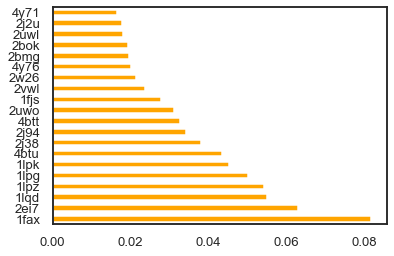

In [61]:
### Random Forest# instantiate a random forest classifier

from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

rf = RandomForestClassifier(n_estimators=300,
                            min_samples_leaf=0.15)# Create a pipe to standarize values

rf.fit(X_train, y_train)

# Predict
y_pred_train = rf.predict_proba(X_train)
y_pred_test = rf.predict_proba(X_test)

# Evaluate
train_roc_auc = roc_auc_score(y_train, y_pred_train[:, 1])
test_roc_auc = roc_auc_score(y_test, y_pred_test[:, 1])

print(train_roc_auc)
print(test_roc_auc)

importances = pd.Series(rf.feature_importances_, index= X.columns)
# sort
importances = importances.sort_values(ascending=False)
importances.iloc[:20].plot(kind='barh', color='orange')
plt.show()

### K-fold CV to evaluate bias-variance trade-off

### Using Docking Scores

In [50]:
library = 'DEKOIS'
score_type = 'Dk_sc'

# Train and test over DEKOIS
X = scores_dic['DEKOIS'][score_type]['X']
y = scores_dic['DEKOIS'][score_type]['y']

In [51]:
estimator = SVC(kernel = 'linear', C = 1e-7, probability=True)

run_cross_val_bias_var_tradeoff(estimator=estimator, X=X, y=y, score_type=score_type)

No. of molecules in train set: 992, with 32 actives.
No. of molecules in test set: 248, with 8 actives.
Coss Validation (cv = 5) mean ROC-AUC: 0.8885
Train ROC-AUC: 0.8891
Test ROC-AUC: 0.8984


In [ ]:
# Pendiente:
# Convertir a una función laa evaluaciones anteriores para evaluar más modelos
# Seleccionar los hiperparámetros de cada modelo
# Contemplar la evaluación sobre DUD y DEKOIS
# Graficar
# Crear ensambles de los modelos

In [44]:
### Voting Classifier: Different Algorithms

In [46]:
from sklearn.ensemble import VotingClassifier

#### Using the wraper

In [171]:
1e-4

0.0001

Model for Dk_sc:
	Best parameters: {'estimator__C': 1e-08}
	Train set accuracy: 0.891
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.0001}
	Train set accuracy: 0.676


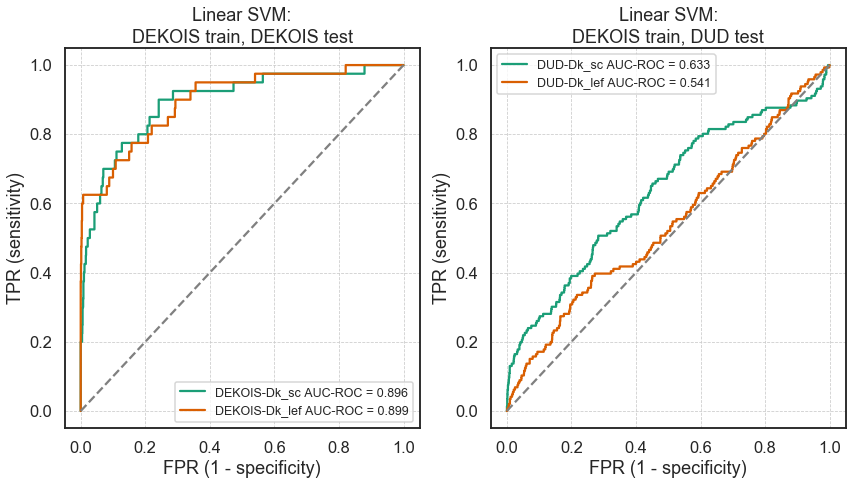

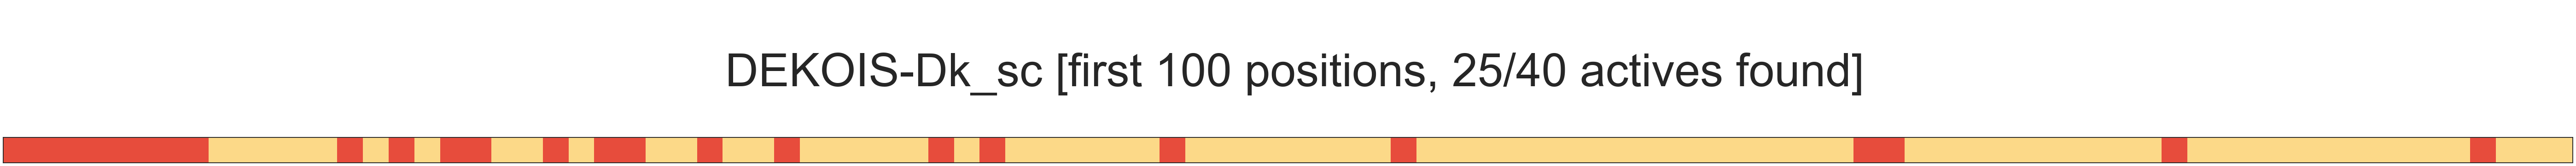

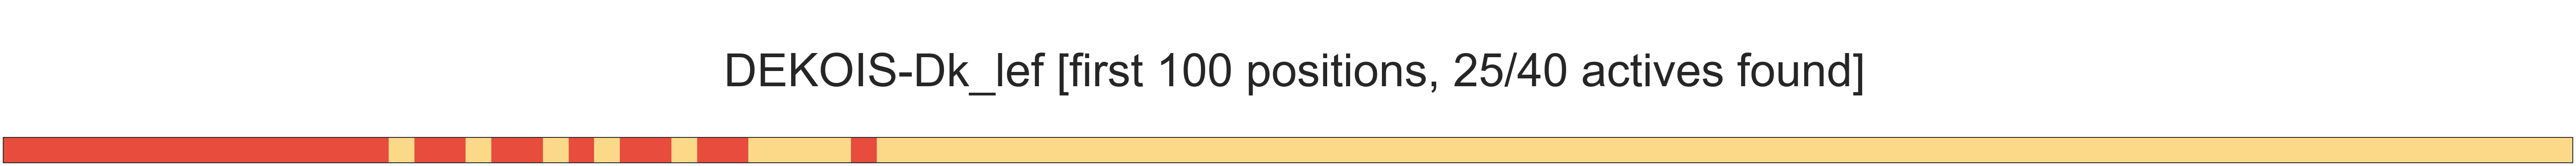

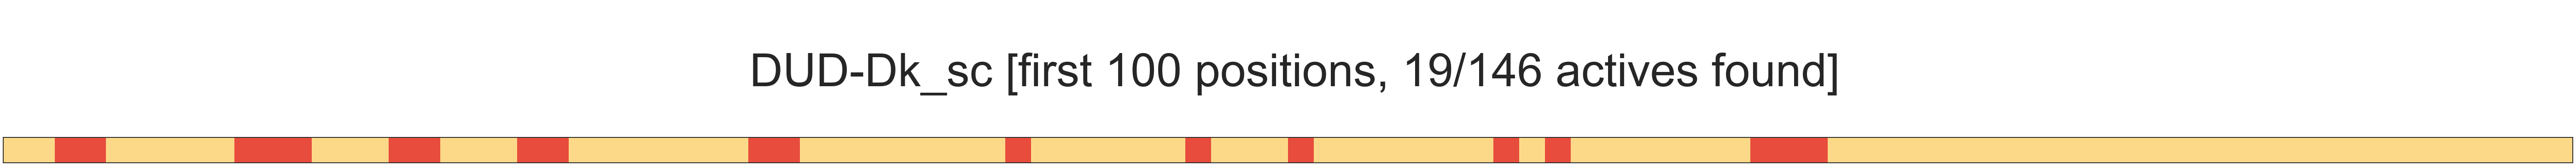

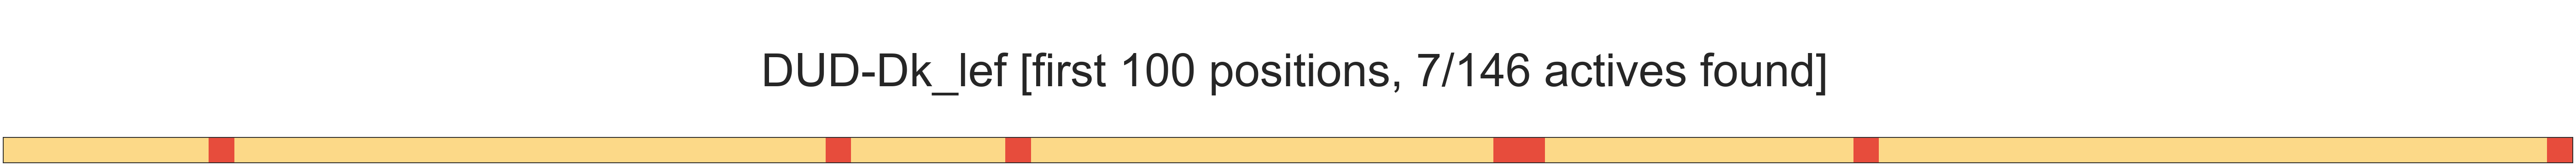

CPU times: user 3.88 s, sys: 254 ms, total: 4.13 s
Wall time: 6.18 s


In [177]:
%%time
# Params to eval through grid search
svc_hyparams = {'C': np.geomspace(1e-8, 1e-0, 5)}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'DEKOIS'
# The name of the datasets which will be used for  testing
test_keys = ['DEKOIS', 'DUD']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores,
                            scores_dic = scores_dic, 
                            estimator= SVC, estimator_hyparams = svc_hyparams,
                            # kwargs exclusive for SVC
                            kernel = 'linear', probability = True)

# Parameters used
for name, model in svm_lineal.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)



###  Radial Basis Function Support Vector Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


Model for Dk_sc:
	Best parameters: {'estimator__C': 0.0001, 'estimator__gamma': 0.0001}
	Train set accuracy: 0.891
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.1, 'estimator__gamma': 0.01}
	Train set accuracy: 0.675


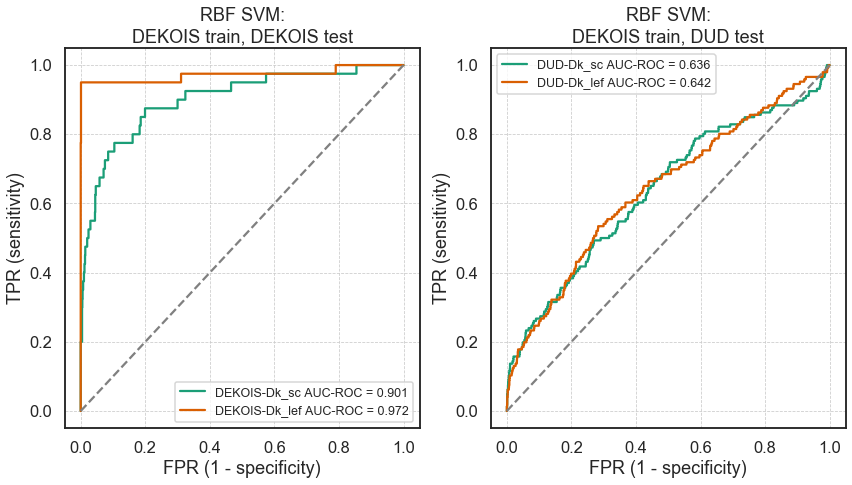

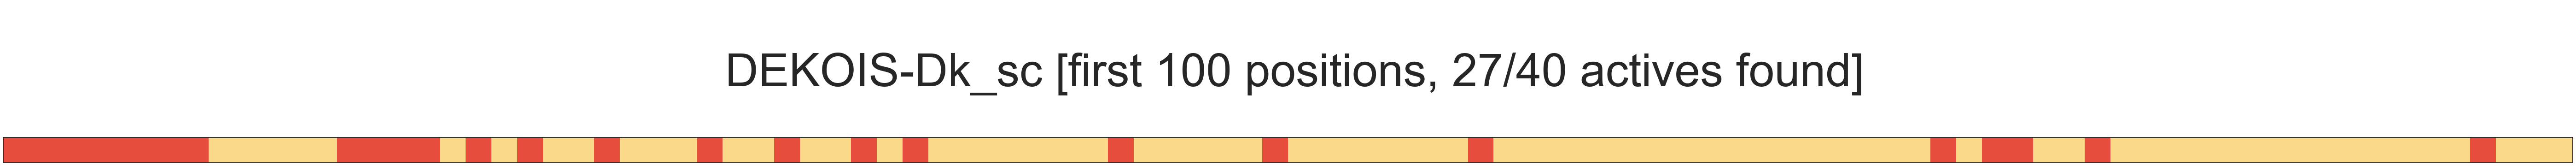

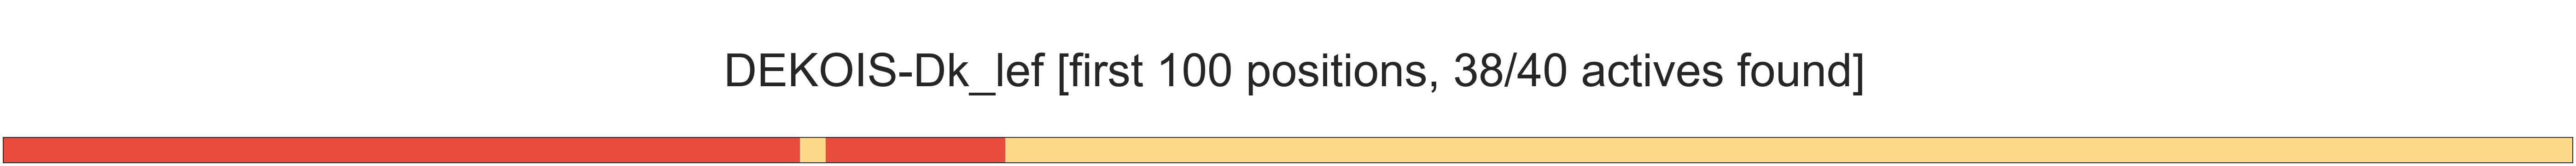

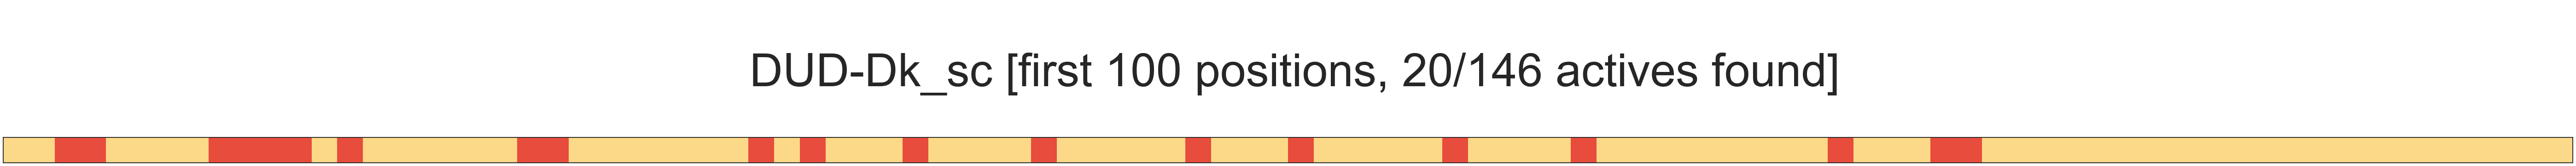

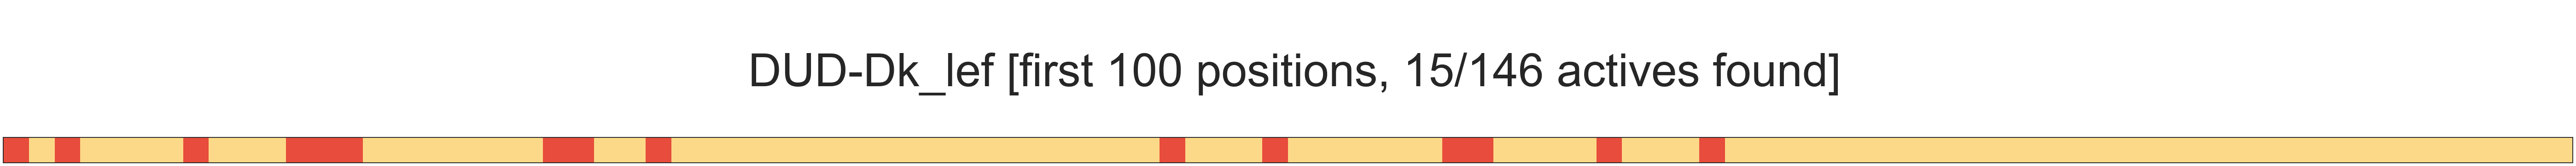

{'estimator__C': 0.0001, 'estimator__gamma': 0.0001}
CPU times: user 4.8 s, sys: 229 ms, total: 5.03 s
Wall time: 9.77 s


In [22]:
%%time
svc_params = {'gamma': [0.0001, 0.001, 0.01],'C': np.geomspace(0.0001, 1, 5)}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']
# Training phase
svm = SVC
svm_rbf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                        scores_dic = scores_dic,
                        estimator= SVC, estimator_hyparams = svc_params,
                        kernel = 'rbf', probability = True)

# Parameters used
for name, model in svm_rbf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
svm_rbf_pred = eval_wrapper(trained_model = svm_rbf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'RBF SVM', predictions = svm_rbf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)
print(svm_rbf['Dk_sc'].best_params_)

### Logistic Regression
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [7]:
from sklearn.linear_model import LogisticRegression

Model for Dk_sc:
	Best parameters: {'estimator__C': 0.001, 'estimator__penalty': 'l2', 'estimator__solver': 'liblinear'}
	Train set accuracy: 0.893
Model for Dk_lef:
	Best parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
	Train set accuracy: 0.739


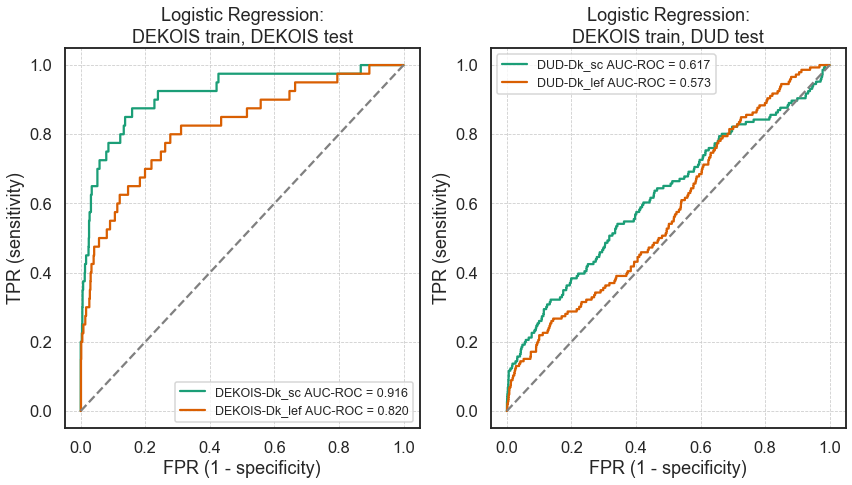

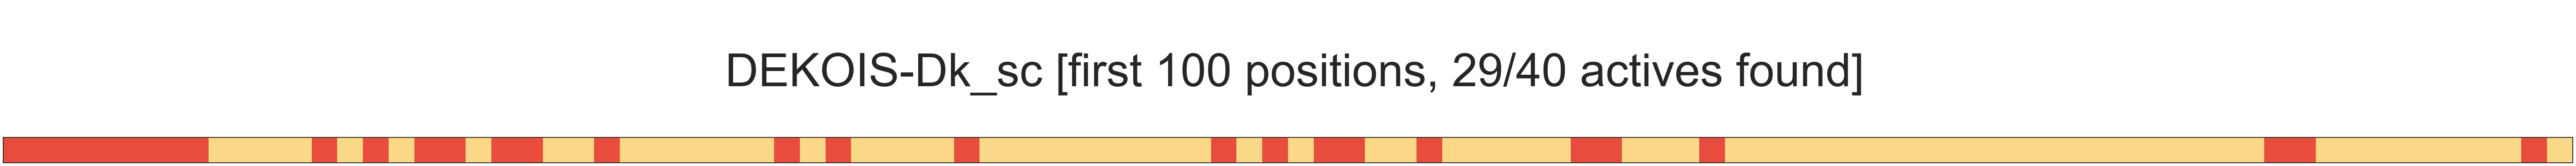

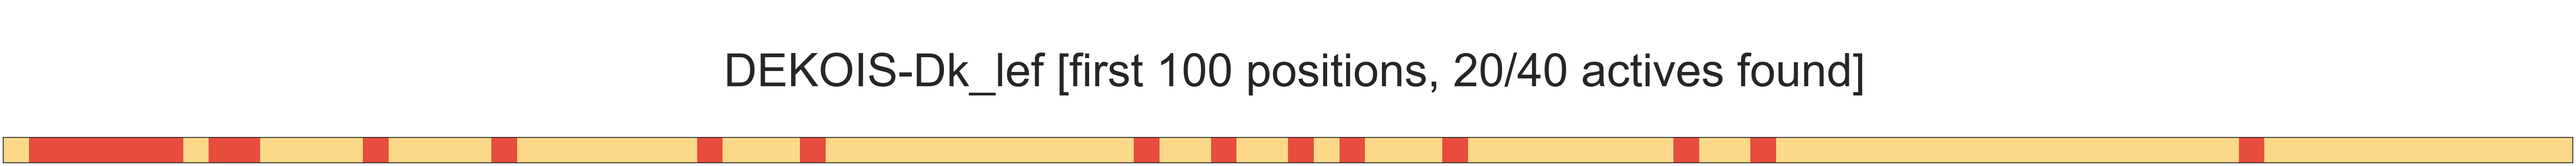

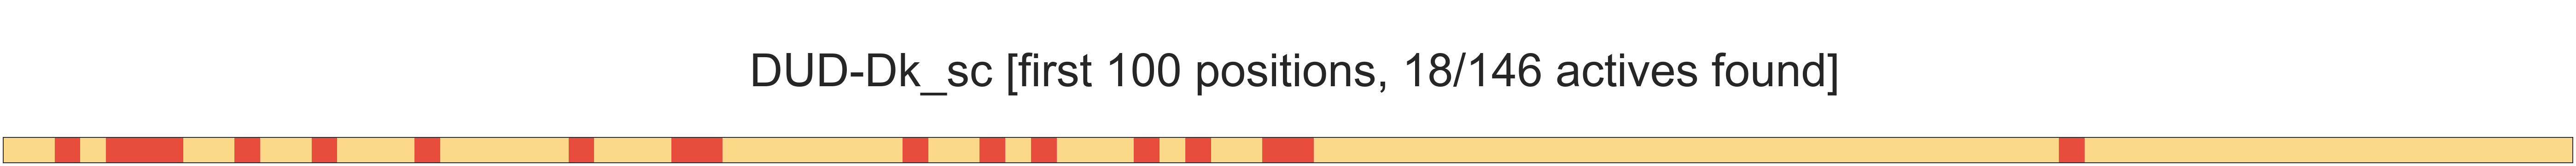

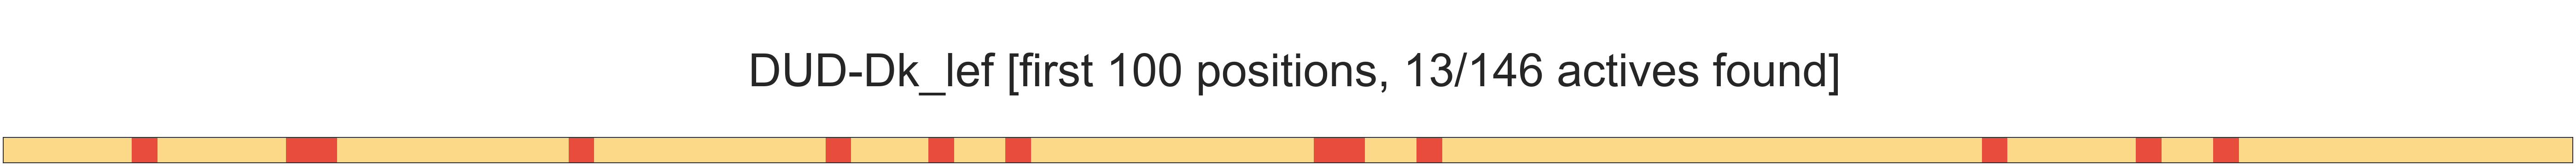

CPU times: user 4.15 s, sys: 731 ms, total: 4.88 s
Wall time: 4.99 s


In [8]:
%%time
lg_params = {'C': [0.0001, 0.001, 0.01, 0.1], 
             'penalty': ['l1', 'l2'], 'solver': ['lbfgs', 'liblinear']}
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
LG = LogisticRegression
lg_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                        estimator= LG, estimator_hyparams = lg_params)
# Parameters used
for name, model in lg_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
lg_clf_pred = eval_wrapper(trained_model = lg_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Logistic Regression', predictions = lg_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

###  Random Forest Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [9]:
from sklearn.ensemble import RandomForestClassifier

Model for Dk_sc:
	Best parameters: {'estimator__max_depth': 10, 'estimator__max_features': 10, 'estimator__max_leaf_nodes': 10, 'estimator__n_estimators': 20}
	Train set accuracy: 0.88
Model for Dk_lef:
	Best parameters: {'estimator__max_depth': 20, 'estimator__max_features': 10, 'estimator__max_leaf_nodes': 20, 'estimator__n_estimators': 30}
	Train set accuracy: 0.71


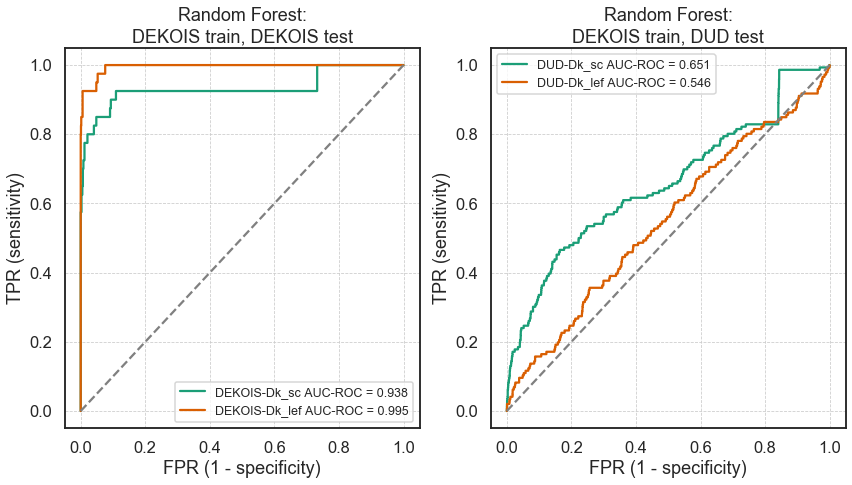

CPU times: user 3.27 s, sys: 914 ms, total: 4.19 s
Wall time: 32.4 s


In [19]:
%%time
rf_params = {'n_estimators': [10, 20, 30],
             'max_features': [10, 20, 30],
             'max_leaf_nodes': [10, 20],
             'max_depth': [10, 20]}

list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
RF = RandomForestClassifier
rf_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, scores_dic = scores_dic,
                       estimator_hyparams = rf_params, standarize = False, estimator= RF,
                       # Hyperparameters
                       n_jobs = -1)

# Parameters used
for name, model in rf_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')

# Evaluation
rf_clf_pred = eval_wrapper(trained_model = rf_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Random Forest', predictions = rf_clf_pred, 
                     train_key = train_key, plot_rankings = False, plot_nef = False)


###  K Nearest Neighbors Classifier
<div style='background-color: #F9E5AB; min-height: 5px'></div>


In [11]:
from sklearn.neighbors import KNeighborsClassifier

Model for Dk_sc:
	Best parameters: {'estimator__n_neighbors': 55, 'estimator__p': 1}
	Train set accuracy: 0.864
Model for Dk_lef:
	Best parameters: {'estimator__n_neighbors': 25, 'estimator__p': 1}
	Train set accuracy: 0.729


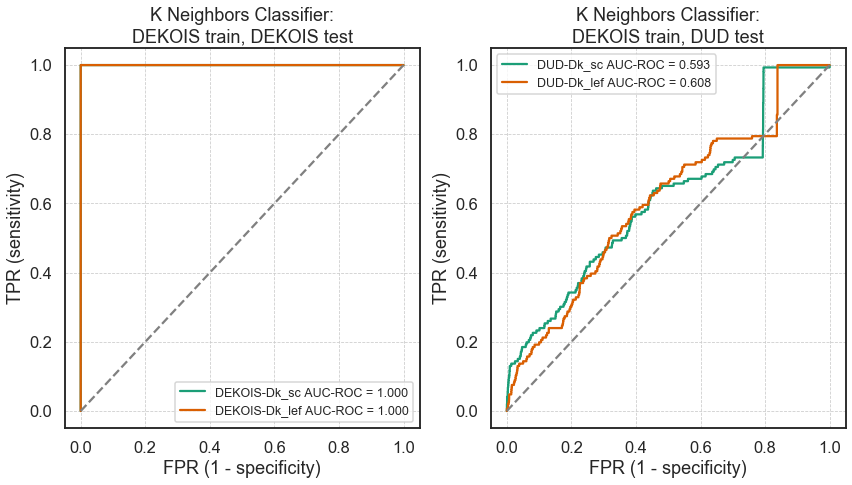

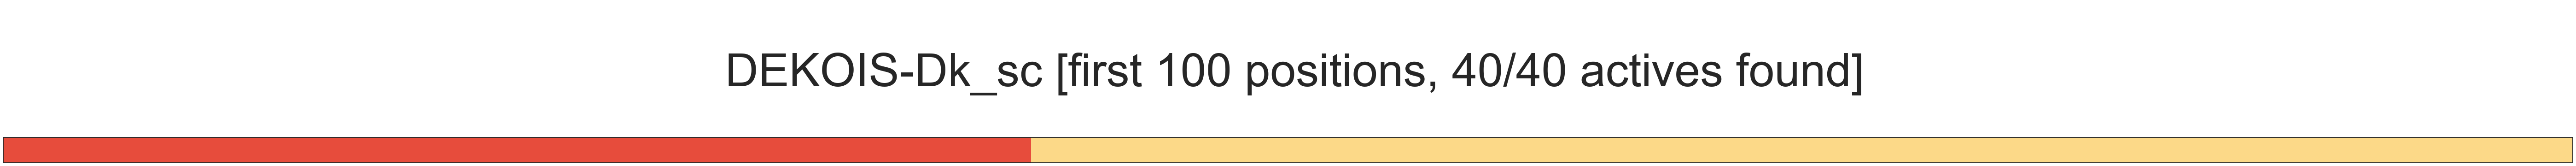

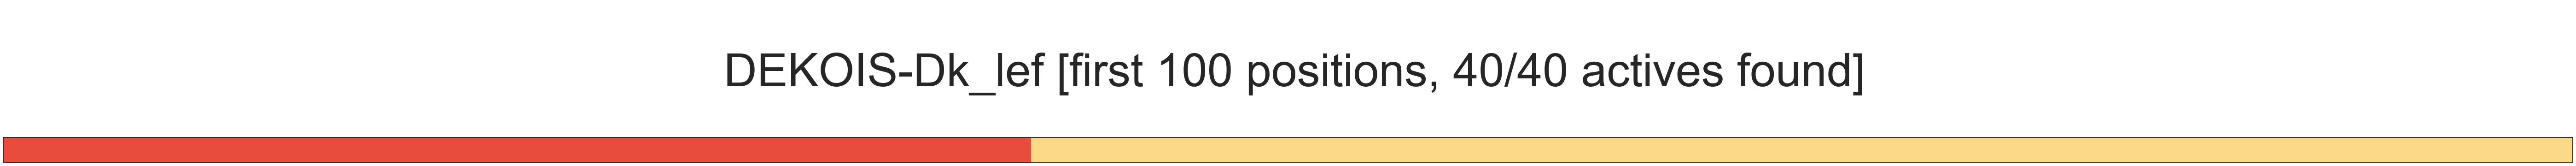

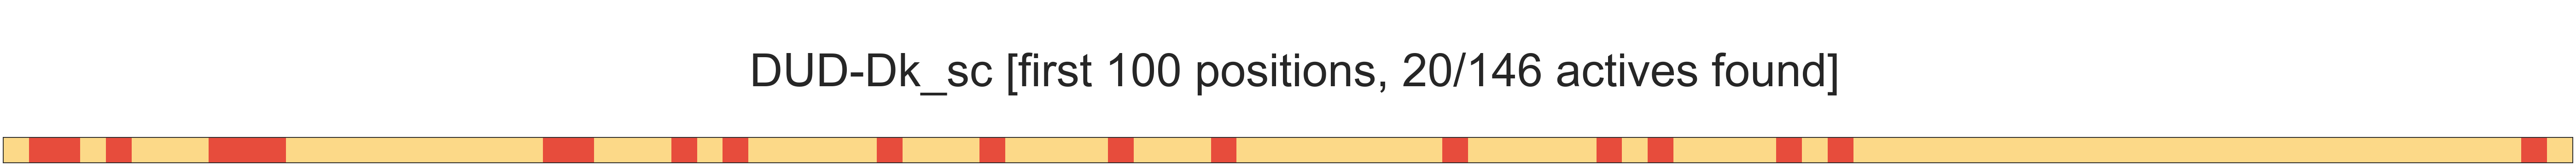

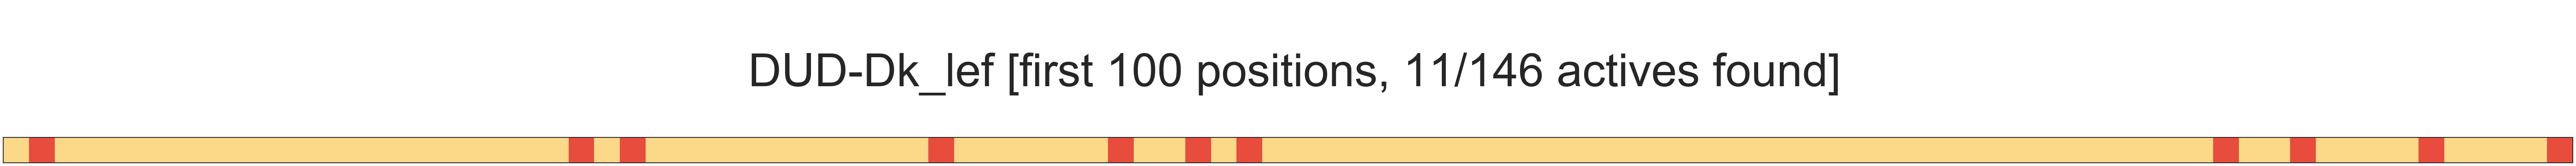

CPU times: user 13.8 s, sys: 251 ms, total: 14 s
Wall time: 8.72 s


In [14]:
%%time
knc_params = {'n_neighbors': [15, 25, 55, 75], 
             'p': [1, 2] # Distance criterion 1: manhattan and 2: euclidean
             }
list_of_scores = ['Dk_sc', 'Dk_lef']
train_key = 'DEKOIS'
test_keys = ['DEKOIS', 'DUD']

# Training phase
KNC = KNeighborsClassifier
knc_clf = train_wrapper(train_key = train_key, list_of_scores = list_of_scores, 
                       scores_dic = scores_dic,
                       estimator= KNC, estimator_hyparams = knc_params,
                        # Hyperparameters
                       algorithm = 'kd_tree', n_jobs = 4, weights = 'distance')
# Parameters used
for name, model in knc_clf.items():
    print(F'Model for {name}:')
    print(F'\tBest parameters: {model.best_params_}')
    print(F'\tTrain set accuracy: {round(model.best_score_, 3)}')
# Evaluation
knc_clf_pred = eval_wrapper(trained_model = knc_clf, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'K Neighbors Classifier', predictions = knc_clf_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

### Recursive Feature Elimination

In [30]:
from sklearn.feature_selection import RFECV

#### DEKOIS Trianing to DUD test

In [45]:
%%time
# Linear SVM as estimator
estimator = SVC(kernel='linear', probability = True, C = 0.01)
# On Docking scores, DEKOIS training
X = scores_dic['DEKOIS']['Dk_sc']['X']
y = scores_dic['DEKOIS']['Dk_sc']['y']

selector = RFECV(estimator, step=1, cv=5, min_features_to_select=2)
selector = selector.fit(X, y)
selector.support_

CPU times: user 52 s, sys: 22.3 s, total: 1min 14s
Wall time: 38.8 s


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [46]:
features_mask = selector.ranking_ == 1
selected_features = X.iloc[:, features_mask].columns
selected_features

Index(['1wu1', '2bmg'], dtype='object')

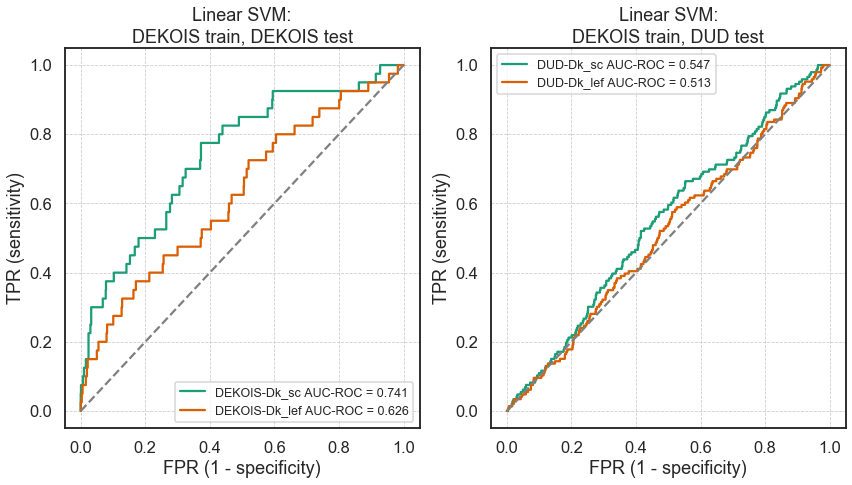

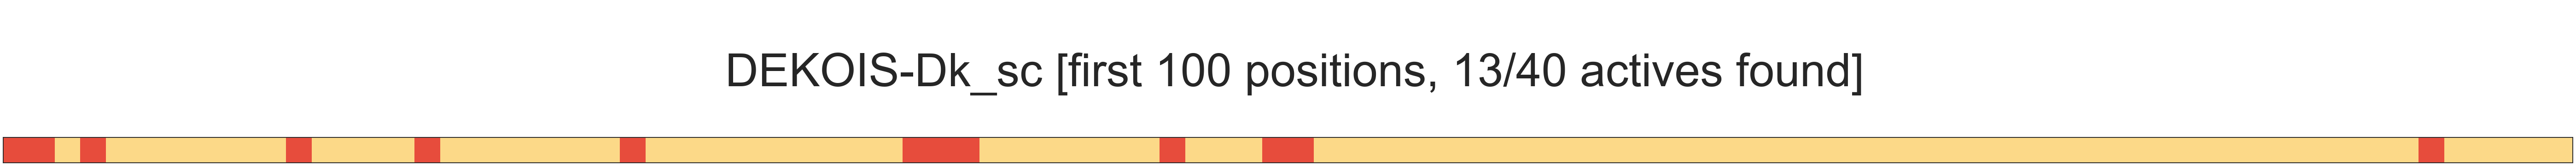

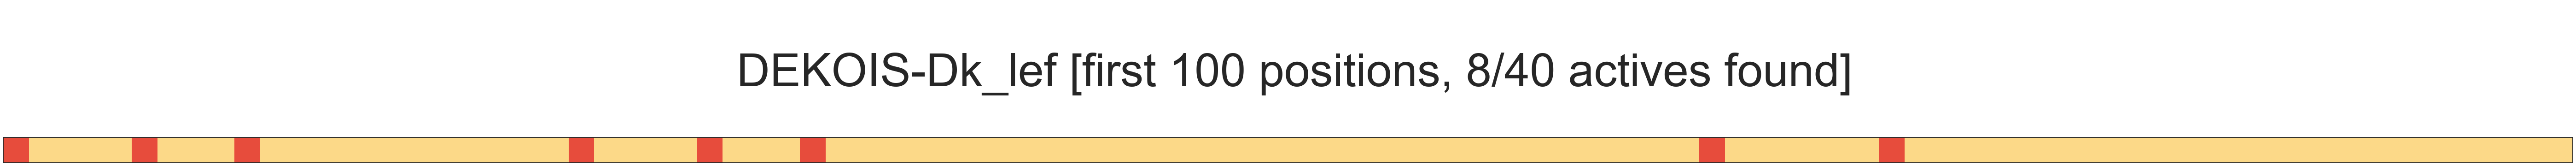

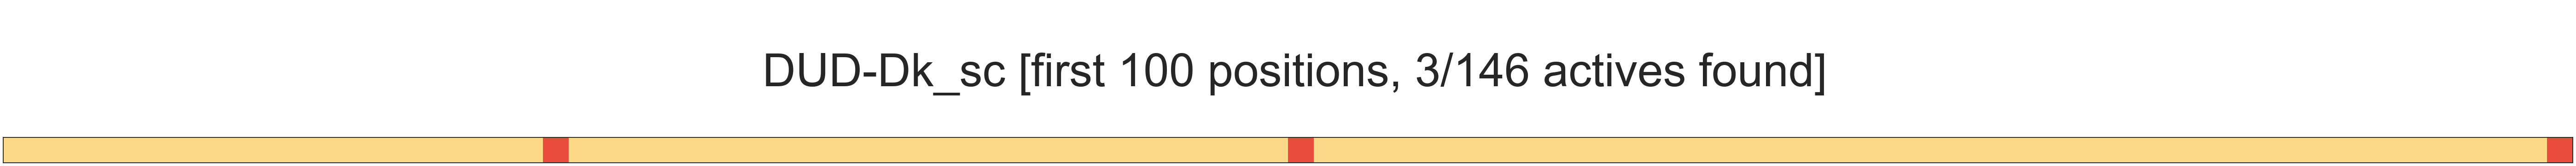

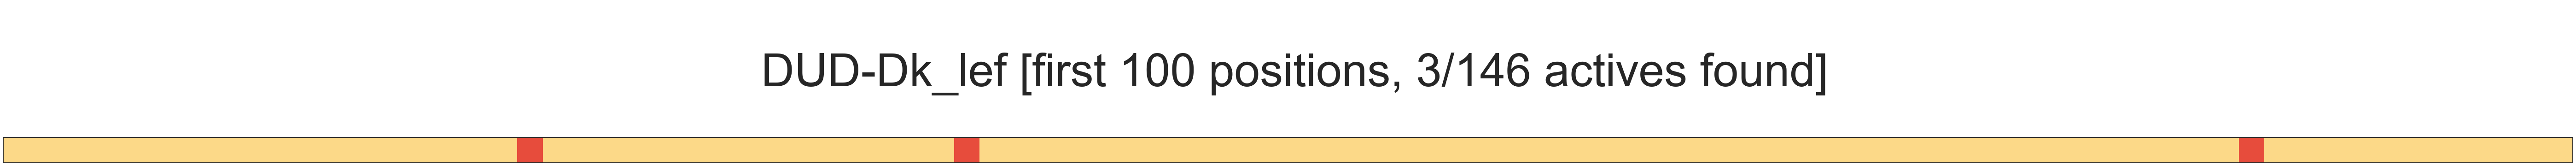

{'estimator__C': 0.001}
CPU times: user 3.07 s, sys: 156 ms, total: 3.23 s
Wall time: 3.24 s


In [47]:
%%time
# Params to eval through grid search
svc_hyparams = {'C': [0.01]}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'DEKOIS'
# The name of the datasets which will be used for  testing
test_keys = ['DEKOIS', 'DUD']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores,
                            scores_dic = scores_dic, selected_features= selected_features,
                            estimator= SVC, estimator_hyparams = svc_hyparams,
                            # kwargs exclusive for SVC
                            kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                               selected_features= selected_features,
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

# Best estimator for DkSc
print(svm_lineal['Dk_sc'].best_params_)

#### DUD Training DEKOIS test

In [48]:
%%time
# Linear SVM as estimator
estimator = SVC(kernel='linear', probability = True, C = 0.01)
# On Docking scores, DEKOIS training
X = scores_dic['DUD']['Dk_sc']['X']
y = scores_dic['DUD']['Dk_sc']['y']

selector = RFECV(estimator, step=1, cv=5, min_features_to_select=2)
selector = selector.fit(X, y)
selector.support_


features_mask = selector.ranking_ == 1
selected_features = X.iloc[:, features_mask].columns
selected_features

CPU times: user 12min 57s, sys: 3min 38s, total: 16min 35s
Wall time: 10min 44s


Index(['1c5m', '1ezq', '1f0r', '1f0s', '1fax', '1fjs', '1g2m', '1hcg', '1ioe',
       '1iqe',
       ...
       '4y6d', '4y76', '4y79', '4y7a', '4y7b', '4zh8', '4zha', '5k0h', '5voe',
       '5vof'],
      dtype='object', length=116)

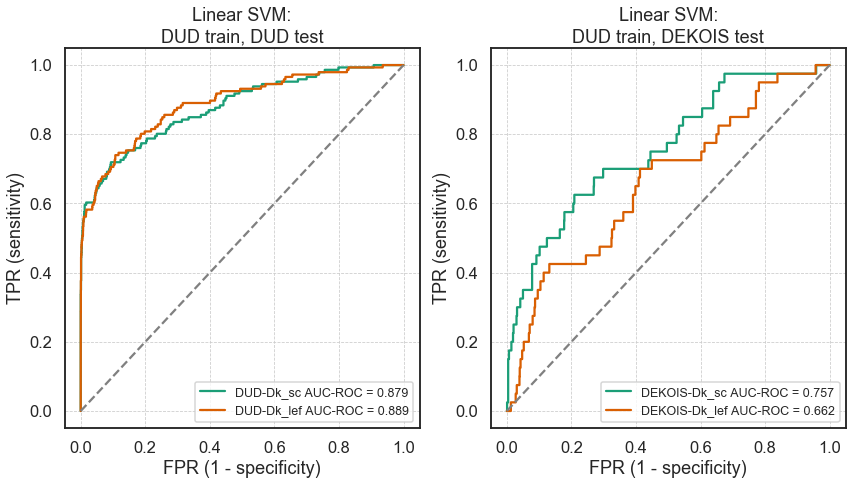

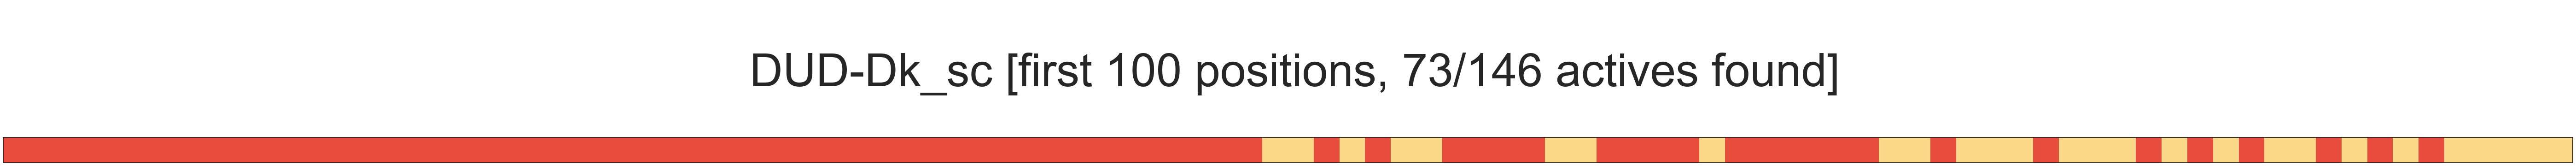

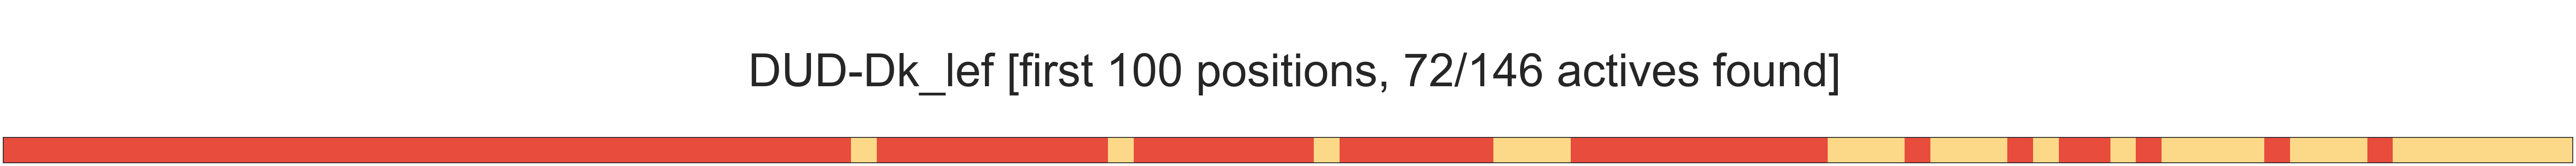

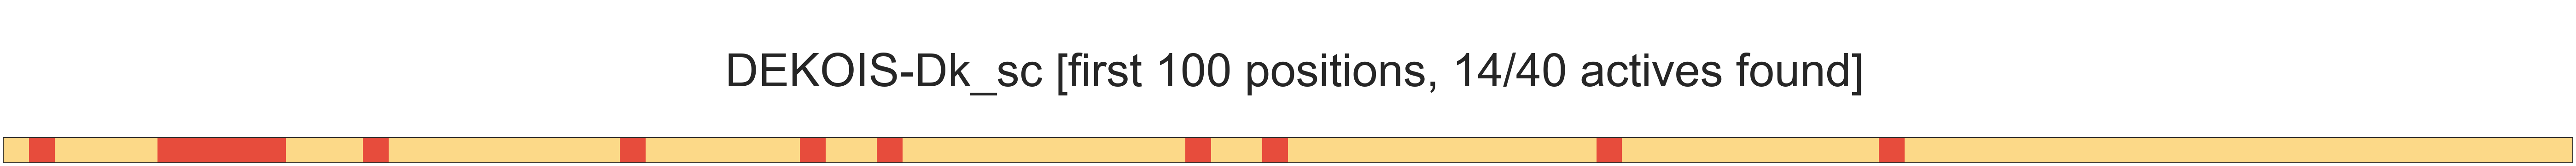

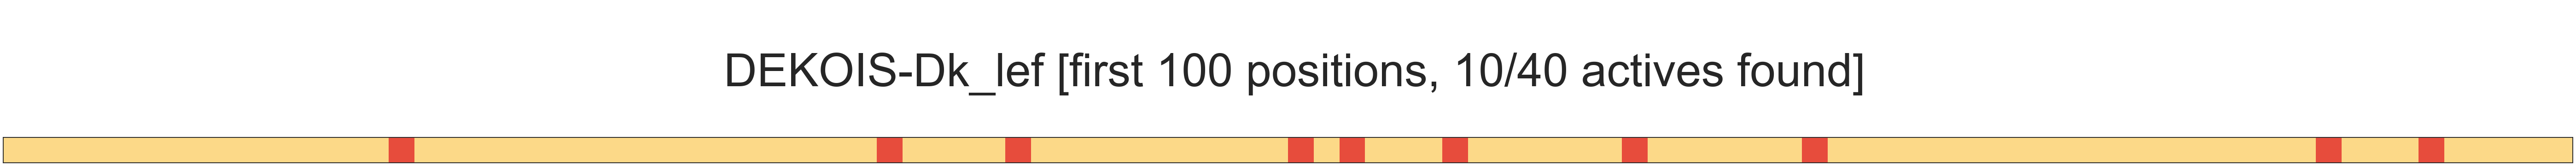

{'estimator__C': 0.01}
CPU times: user 8.63 s, sys: 713 ms, total: 9.34 s
Wall time: 28.9 s


In [49]:
%%time
# Params to eval through grid search
svc_hyparams = {'C': [0.01]}
# IMPORTANT: The following code trains as many models as the the number of elements in list_of_scores
list_of_scores = ['Dk_sc', 'Dk_lef']
# In this case, one model will be train for CSAR-Dk_sc and a different model for CSAR-Dk_leff

# The dataset that will be used for trining the model
train_key = 'DUD'
# The name of the datasets which will be used for  testing
test_keys = ['DUD', 'DEKOIS']

# TRAINING PHASE: The algorithm only 'sees' the train_key set
svm = SVC # Intance the estimator to be used
svm_lineal = train_wrapper(train_key = train_key, list_of_scores = list_of_scores,
                            scores_dic = scores_dic, selected_features= selected_features,
                            estimator= SVC, estimator_hyparams = svc_hyparams,
                            # kwargs exclusive for SVC
                            kernel = 'linear', probability = True)

# TESTING PHASE: Evaluation of the model with the given sets (test_keys)
svm_lineal_pred = eval_wrapper(trained_model = svm_lineal, 
                            test_keys = test_keys, list_of_scores = list_of_scores, 
                               selected_features= selected_features,
                            scores_dic = scores_dic, decreasing = False)
# Visualization
plot_predict_results(title = 'Linear SVM', predictions = svm_lineal_pred, 
                     train_key = train_key, plot_rankings = True, plot_nef = False)

# Best estimator for DkSc
print(svm_lineal['Dk_sc'].best_params_)

#### 